# Banana Ripeness Classification with PyTorch CNN

This notebook implements a state-of-the-art CNN classifier using PyTorch and transfer learning with ResNet50 for classifying banana ripeness into 6 categories:
- Fresh Ripe
- Fresh Unripe
- Overripe
- Ripe
- Rotten
- Unripe

## 1. Mount Google Drive

This will allow you to access your dataset from Google Drive. You'll be prompted to authorize access.

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

print("\n✓ Google Drive mounted successfully!")
print("Your Drive files are available at: /content/drive/MyDrive/")

Mounted at /content/drive

✓ Google Drive mounted successfully!
Your Drive files are available at: /content/drive/MyDrive/


## 2. Define Dataset Paths


In [ ]:

# Path to your dataset in Google Drive
drive_dataset_path = '/content/drive/MyDrive/Banana Ripeness Classification.v1i.folder'
# ==============================

# Define paths to train, valid, test
data_dir = drive_dataset_path
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Verify paths exist
print("Checking dataset paths...")
print("=" * 50)
print(f"Dataset directory: {data_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Valid directory exists: {os.path.exists(valid_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

if not os.path.exists(data_dir):
    print("\n ERROR: Dataset directory not found!")
    print("Please update the 'drive_dataset_path' variable above to match your Google Drive folder structure.")

else:
    print("\n✓ Dataset found successfully!")

Checking dataset paths...
Dataset directory: /content/drive/MyDrive/Banana Ripeness Classification.v1i.folder
Train directory exists: True
Valid directory exists: True
Test directory exists: True

✓ Dataset found successfully!


## 3. Import Libraries and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
import copy
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available (Colab provides free GPU!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("\n⚠️ No GPU detected. Training will be slower.")
    print("To enable GPU in Colab: Runtime → Change runtime type → Hardware accelerator → GPU")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


## 4. Data Augmentation and Preprocessing

In [ ]:
# Image size for ResNet
img_size = 224

# Data augmentation for training - helps prevent overfitting
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

# Validation and test transforms - no augmentation
val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Transforms defined successfully!")

✓ Transforms defined successfully!


## 5. Create Datasets and DataLoaders

In [ ]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"\nBatch size: {batch_size}")
print(f"Number of batches - Train: {len(train_loader)}, Valid: {len(valid_loader)}, Test: {len(test_loader)}")

Number of classes: 6
Classes: ['freshripe', 'freshunripe', 'overripe', 'ripe', 'rotten', 'unripe']

Training samples: 3931
Validation samples: 1123
Test samples: 562

Batch size: 32
Number of batches - Train: 123, Valid: 36, Test: 18


## 6. Visualize Sample Images

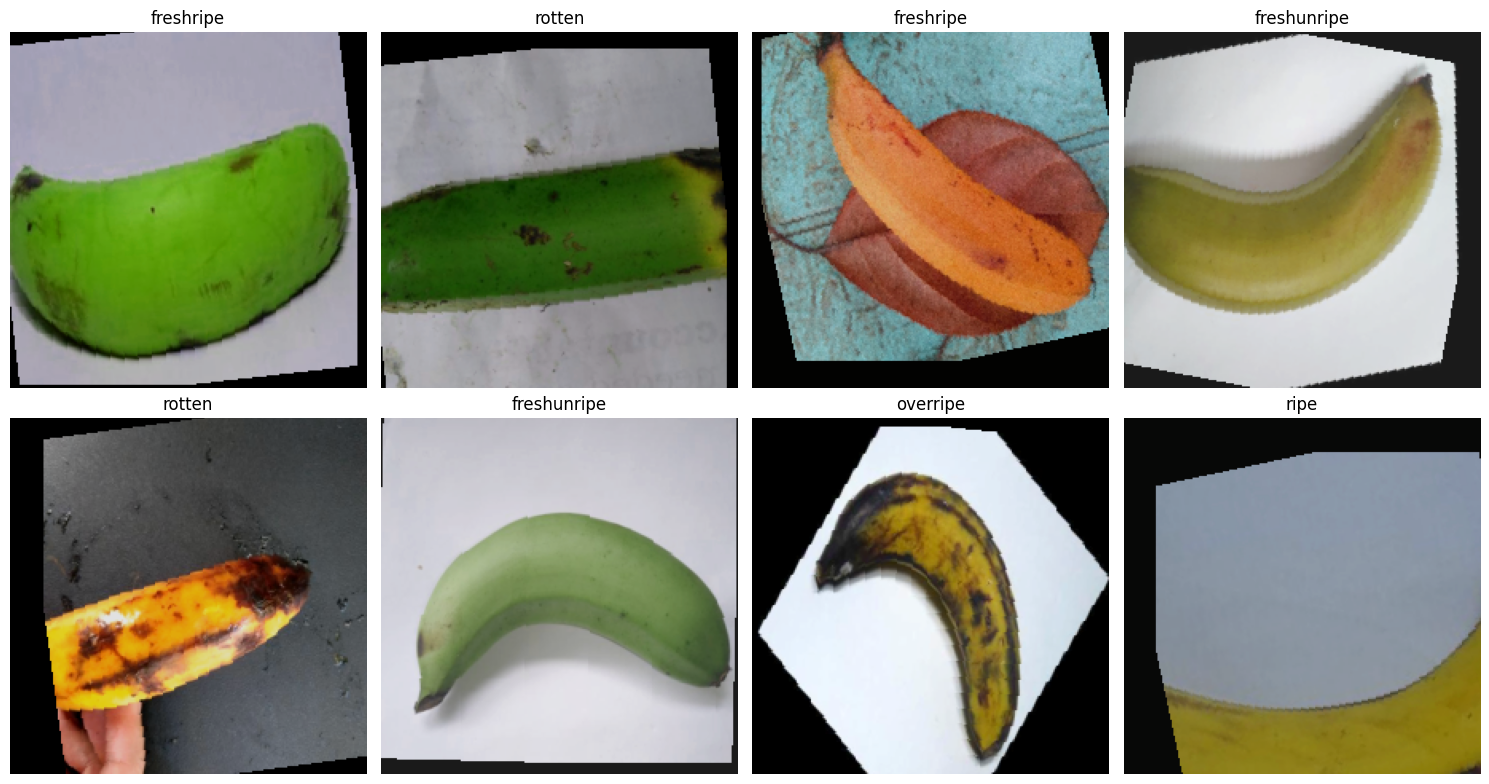

In [ ]:
def imshow(img, title=None):
    """Display a tensor image"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Display 8 sample images
fig = plt.figure(figsize=(15, 8))
for idx in range(min(8, batch_size)):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    imshow(inputs[idx], title=class_names[classes[idx]])
plt.tight_layout()
plt.show()

## 7. Define the CNN Model (ResNet50)

In [ ]:
def create_model(num_classes, pretrained=True):

    # Load pretrained ResNet50
    model = models.resnet50(pretrained=pretrained)

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model

# Create the model
print("Creating model...")
model = create_model(num_classes, pretrained=True)
model = model.to(device)

print("✓ Model created successfully!")
print(f"Model is on: {next(model.parameters()).device}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Creating model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


✓ Model created successfully!
Model is on: cuda:0

Total parameters: 24,560,198
Trainable parameters: 1,052,166


## 8. Define Loss Function and Optimizer

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

print("✓ Loss function and optimizer defined!")

✓ Loss function and optimizer defined!


## 9. Training and Validation Functions

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

print("✓ Training and validation functions defined!")

✓ Training and validation functions defined!


## 10. Train the Model

In [ ]:
# Training parameters
num_epochs = 25
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...")
print("=" * 60)

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"✓ New best model saved! (Val Acc: {val_acc:.4f})")

training_time = time.time() - start_time

print("\n" + "=" * 60)
print(f"Training completed in {training_time // 60:.0f}m {training_time % 60:.0f}s")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Starting training for 25 epochs...

Epoch 1/25
----------------------------------------


Validation: 100%|██████████| 36/36 [08:12<00:00, 13.69s/it]



Train Loss: 0.7796 | Train Acc: 0.7258
Val Loss: 0.3250 | Val Acc: 0.8833
✓ New best model saved! (Val Acc: 0.8833)

Epoch 2/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s]



Train Loss: 0.4885 | Train Acc: 0.8240
Val Loss: 0.2341 | Val Acc: 0.9314
✓ New best model saved! (Val Acc: 0.9314)

Epoch 3/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s]



Train Loss: 0.4091 | Train Acc: 0.8471
Val Loss: 0.2563 | Val Acc: 0.9056

Epoch 4/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.54it/s]



Train Loss: 0.4406 | Train Acc: 0.8438
Val Loss: 0.2491 | Val Acc: 0.9092

Epoch 5/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s]



Train Loss: 0.4096 | Train Acc: 0.8494
Val Loss: 0.2203 | Val Acc: 0.9252

Epoch 6/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.41it/s]



Train Loss: 0.3700 | Train Acc: 0.8649
Val Loss: 0.2234 | Val Acc: 0.9234

Epoch 7/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Train Loss: 0.3827 | Train Acc: 0.8583
Val Loss: 0.2150 | Val Acc: 0.9243

Epoch 8/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.11it/s]



Train Loss: 0.3809 | Train Acc: 0.8578
Val Loss: 0.1955 | Val Acc: 0.9350
✓ New best model saved! (Val Acc: 0.9350)

Epoch 9/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.04it/s]



Train Loss: 0.3639 | Train Acc: 0.8675
Val Loss: 0.1960 | Val Acc: 0.9394
✓ New best model saved! (Val Acc: 0.9394)

Epoch 10/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.09it/s]



Train Loss: 0.3645 | Train Acc: 0.8654
Val Loss: 0.1791 | Val Acc: 0.9430
✓ New best model saved! (Val Acc: 0.9430)

Epoch 11/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.06it/s]



Train Loss: 0.3533 | Train Acc: 0.8677
Val Loss: 0.2222 | Val Acc: 0.9252

Epoch 12/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.09it/s]



Train Loss: 0.3392 | Train Acc: 0.8700
Val Loss: 0.1600 | Val Acc: 0.9484
✓ New best model saved! (Val Acc: 0.9484)

Epoch 13/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.04it/s]



Train Loss: 0.3252 | Train Acc: 0.8799
Val Loss: 0.2062 | Val Acc: 0.9323

Epoch 14/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.22it/s]



Train Loss: 0.3213 | Train Acc: 0.8812
Val Loss: 0.1769 | Val Acc: 0.9457

Epoch 15/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.12it/s]



Train Loss: 0.3070 | Train Acc: 0.8815
Val Loss: 0.2038 | Val Acc: 0.9270

Epoch 16/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.05it/s]



Train Loss: 0.2983 | Train Acc: 0.8878
Val Loss: 0.2114 | Val Acc: 0.9305

Epoch 17/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.02it/s]



Train Loss: 0.2939 | Train Acc: 0.8911
Val Loss: 0.1610 | Val Acc: 0.9501
✓ New best model saved! (Val Acc: 0.9501)

Epoch 18/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.02it/s]



Train Loss: 0.2733 | Train Acc: 0.8985
Val Loss: 0.1684 | Val Acc: 0.9492

Epoch 19/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.66it/s]



Train Loss: 0.2637 | Train Acc: 0.9061
Val Loss: 0.1625 | Val Acc: 0.9448

Epoch 20/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s]



Train Loss: 0.2648 | Train Acc: 0.9036
Val Loss: 0.1465 | Val Acc: 0.9537
✓ New best model saved! (Val Acc: 0.9537)

Epoch 21/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.33it/s]



Train Loss: 0.2716 | Train Acc: 0.8995
Val Loss: 0.1554 | Val Acc: 0.9519

Epoch 22/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.48it/s]



Train Loss: 0.2599 | Train Acc: 0.9041
Val Loss: 0.1510 | Val Acc: 0.9537

Epoch 23/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:09<00:00,  3.81it/s]



Train Loss: 0.2503 | Train Acc: 0.9026
Val Loss: 0.1531 | Val Acc: 0.9546
✓ New best model saved! (Val Acc: 0.9546)

Epoch 24/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.17it/s]



Train Loss: 0.2614 | Train Acc: 0.9054
Val Loss: 0.1480 | Val Acc: 0.9546

Epoch 25/25
----------------------------------------


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.03it/s]


Train Loss: 0.2474 | Train Acc: 0.9122
Val Loss: 0.1474 | Val Acc: 0.9555
✓ New best model saved! (Val Acc: 0.9555)

Training completed in 55m 42s
Best validation accuracy: 0.9555


<All keys matched successfully>

## 11. Visualize Training History

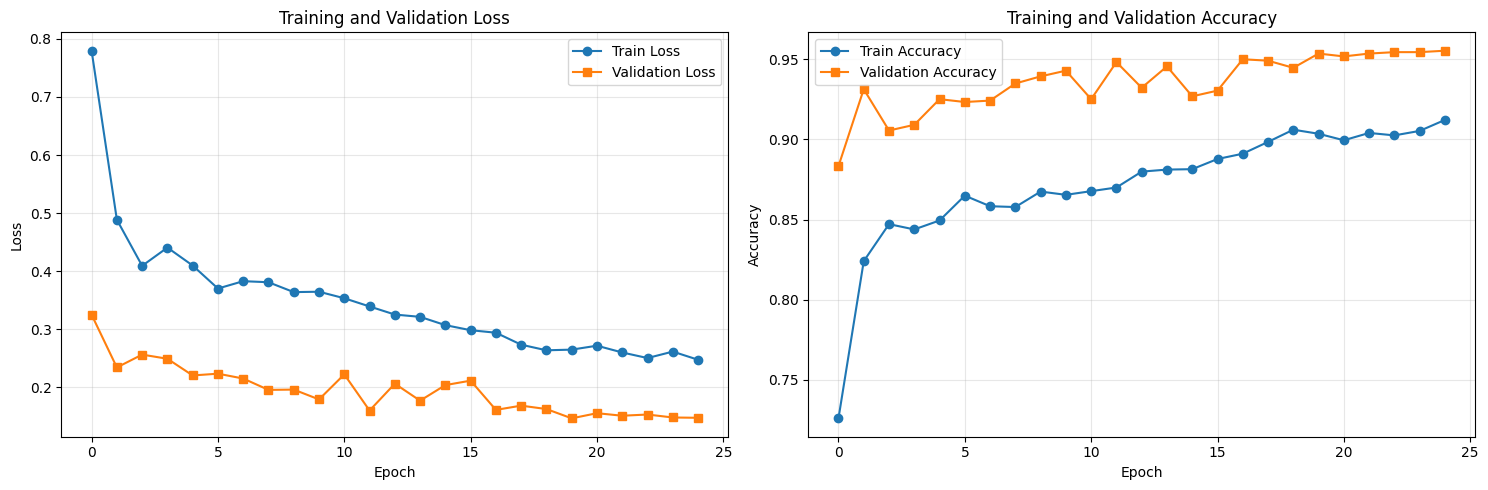

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Evaluate on Test Set

In [ ]:
def evaluate_model(model, dataloader, device):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions on test set
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(test_labels, test_preds, target_names=class_names))

Testing: 100%|██████████| 18/18 [04:17<00:00, 14.29s/it]


Test Accuracy: 0.9288

Classification Report:
              precision    recall  f1-score   support

   freshripe       0.92      0.94      0.93       102
 freshunripe       1.00      1.00      1.00        83
    overripe       0.89      0.97      0.93       113
        ripe       0.77      0.71      0.74        52
      rotten       0.97      0.93      0.95       185
      unripe       0.92      0.89      0.91        27

    accuracy                           0.93       562
   macro avg       0.91      0.91      0.91       562
weighted avg       0.93      0.93      0.93       562



## 13. Confusion Matrix

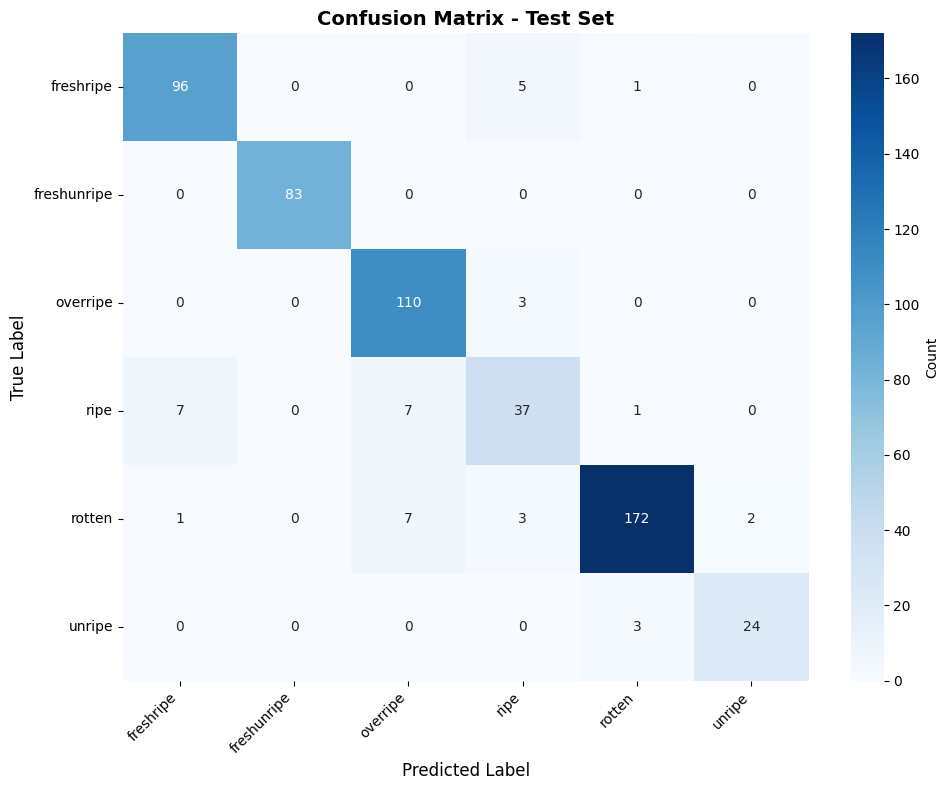


Per-Class Accuracy:
freshripe      : 0.9412 (96/102)
freshunripe    : 1.0000 (83/83)
overripe       : 0.9735 (110/113)
ripe           : 0.7115 (37/52)
rotten         : 0.9297 (172/185)
unripe         : 0.8889 (24/27)


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("=" * 40)
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name:15s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

## 14. Visualize Predictions

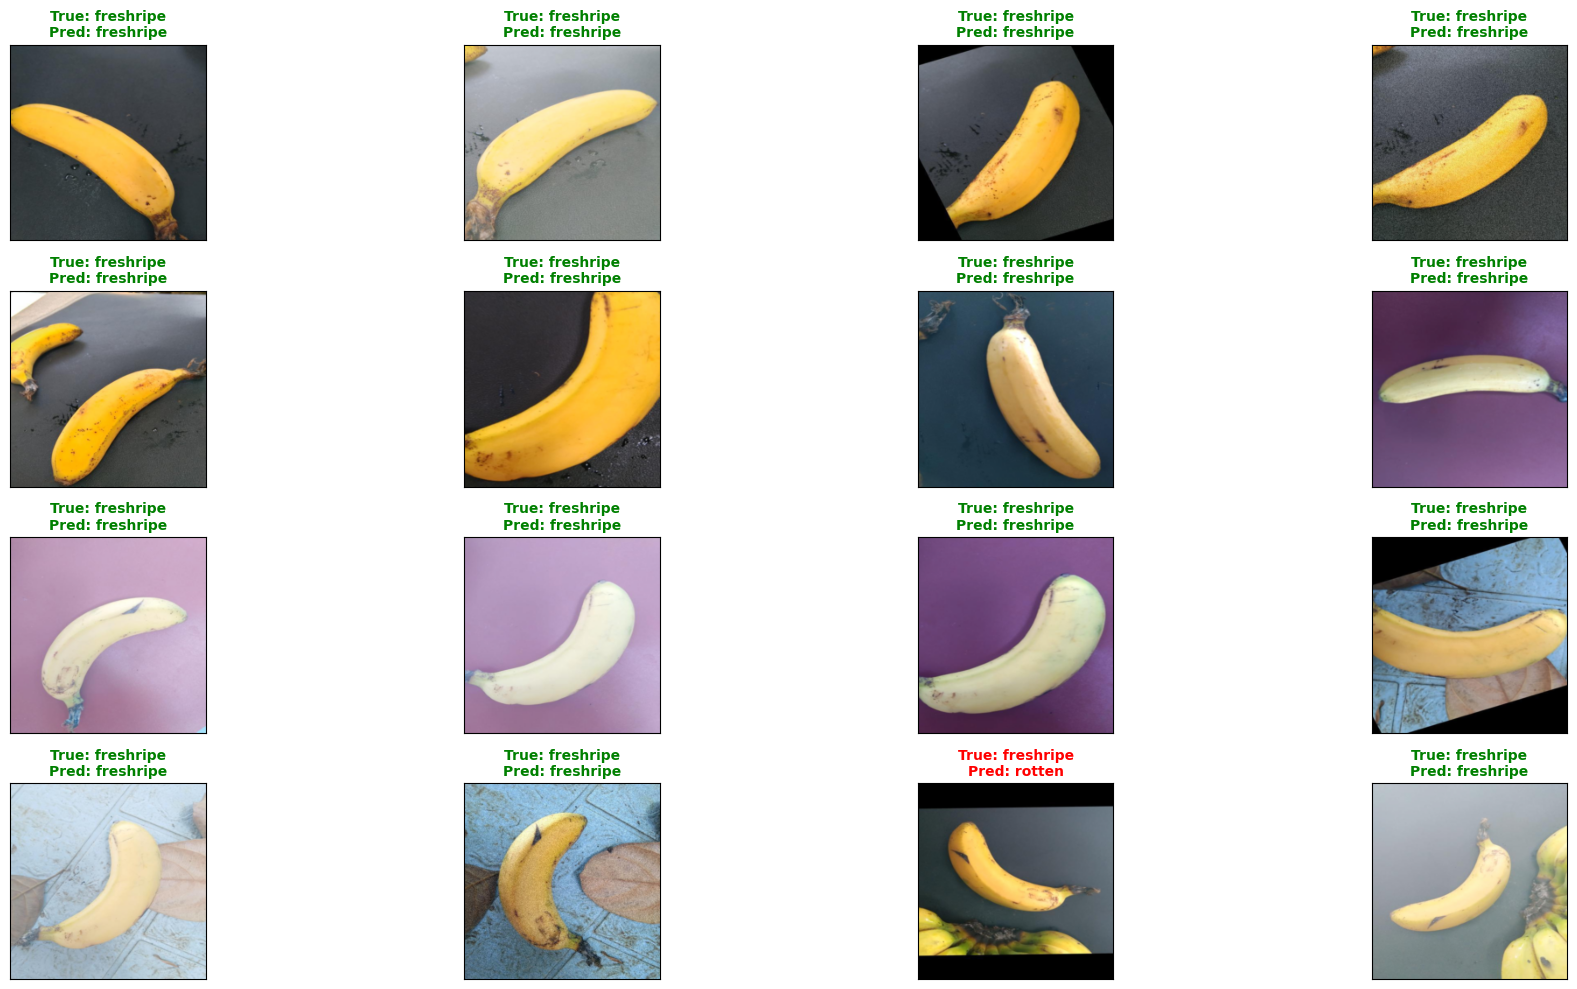

In [ ]:
def visualize_predictions(model, dataloader, class_names, device, num_images=16):

    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                ax = fig.add_subplot(4, 4, images_shown + 1, xticks=[], yticks=[])

                # Display image
                img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                # Set title with prediction and true label
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                color = 'green' if preds[i] == labels[i] else 'red'
                ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                           color=color, fontsize=10, fontweight='bold')

                images_shown += 1

    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
visualize_predictions(model, test_loader, class_names, device, num_images=16)

## 15. Save the Model to Google Drive

In [ ]:
# Save the complete model to Google Drive
model_save_path = '/content/drive/MyDrive/banana_ripeness_resnet50.pth'

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'test_acc': test_accuracy,
    'class_names': class_names,
}, model_save_path)

print(f"✓ Model saved to Google Drive: {model_save_path}")
print(f"\nModel Summary:")
print(f"  Architecture: ResNet50 with transfer learning")
print(f"  Number of classes: {num_classes}")
print(f"  Best validation accuracy: {best_val_acc:.4f}")
print(f"  Test accuracy: {test_accuracy:.4f}")

✓ Model saved to Google Drive: /content/drive/MyDrive/banana_ripeness_resnet50.pth

Model Summary:
  Architecture: ResNet50 with transfer learning
  Number of classes: 6
  Best validation accuracy: 0.9555
  Test accuracy: 0.9288


## 16. Making Predictions on New Images

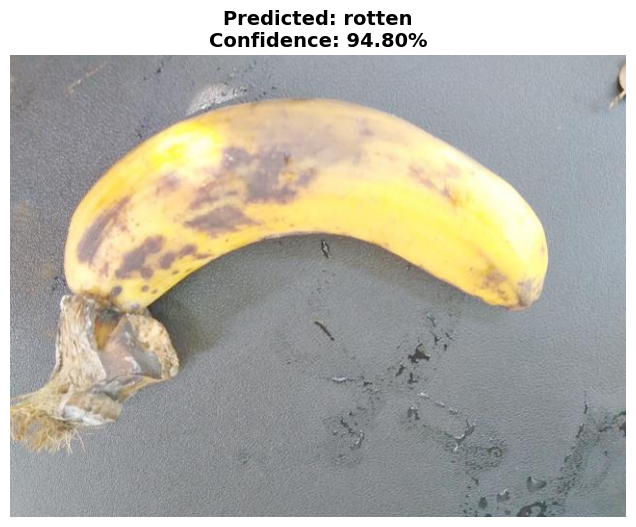


Class Probabilities:
freshripe      : 0.0303 (3.03%)
freshunripe    : 0.0000 (0.00%)
overripe       : 0.0006 (0.06%)
ripe           : 0.0211 (2.11%)
rotten         : 0.9480 (94.80%)
unripe         : 0.0000 (0.00%)


In [ ]:
from PIL import Image

def predict_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a single image

    Args:
        image_path: Path to the image file (can be in Google Drive)
        model: Trained model
        transform: Image transformation pipeline
        class_names: List of class names
        device: Device to run inference on
    """
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    # Display image and prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.2%}",
             fontsize=14, fontweight='bold')
    plt.show()

    # Print all class probabilities
    print("\nClass Probabilities:")
    print("=" * 40)
    probs = probabilities[0].cpu().numpy()
    for i, (class_name, prob) in enumerate(zip(class_names, probs)):
        print(f"{class_name:15s}: {prob:.4f} ({prob*100:.2f}%)")

    return predicted_class, confidence_score

# Example usage:
image_path = '/content/drive/MyDrive/Banana Ripeness Classification.v1i.folder/test/rotten/musa-acuminata-banana-8f139d59-394a-11ec-91b5-d8c4975e38aa_jpg.rf.c2a857c1ed4bf81be88dff7d34bf8191.jpg'
predicted_class, confidence = predict_image(image_path, model, val_test_transforms, class_names, device)